In [1]:
import torch
import cv2
from time import time
import matplotlib.pyplot as plt
from diff3f_copy import get_features_per_vertex
from utils import convert_mesh_container_to_torch_mesh, cosine_similarity, double_plot, get_colors, generate_colors, plot_mesh
from dataloaders.mesh_container import MeshContainer
from diffusion import init_pipe
from dino_copy import init_dino
from functional_map import compute_surface_map

/home/aaryap/miniconda3/envs/diff3f/lib/python3.10/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
device = torch.device('cuda:0')
torch.cuda.set_device(device)
num_views = 100
H = 512
W = 512
num_images_per_prompt = 1
tolerance = 0.004
random_seed = 42
use_normal_map = True

In [3]:
def compute_features(device, pipe, dino_model, m, prompt, real_world_image=None):
    mesh = convert_mesh_container_to_torch_mesh(m, device=device, is_tosca=False)
    mesh_vertices = mesh.verts_list()[0]
    features = get_features_per_vertex(
        device=device,
        pipe=pipe, 
        dino_model=dino_model,
        mesh=mesh,
        prompt=prompt,
        mesh_vertices=mesh_vertices,
        num_views=num_views,
        H=H,
        W=W,
        tolerance=tolerance,
        num_images_per_prompt=num_images_per_prompt,
        use_normal_map=use_normal_map,
        real_world_image = real_world_image
    )
    return features.cpu()

In [4]:
pipe = init_pipe(device)
dino_model = init_dino(device)

/home/aaryap/miniconda3/envs/diff3f/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/aaryap/miniconda3/envs/diff3f/lib/python3.10/site-packages/diffusers/configuration_utils.py:239: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a model, please use <class 'unet_2d_condition.UNet2DConditionModel'>.load_config(...) followed by <class 'unet_2d_condition.UNet2DConditionModel'>.from_config(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'pipeline_controlnet_img2img.StableDiffusionControlNetImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
Using cache found in /home/aaryap/.cache/torch/hub/facebookresearch_dinov2_main
/home/aaryap/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/aaryap/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: Use

In [42]:
source_file_path = "meshes/cow.obj"
target_file_path = "meshes/camel.obj"
source_mesh = MeshContainer().load_from_file(source_file_path)
target_mesh = MeshContainer().load_from_file(target_file_path)

# read real-world image
real_image_path = "images/cow.png"
cow_image = cv2.imread(real_image_path)
real_image_path = "images/cow_left.jpg"
cow_left_image = cv2.imread(real_image_path)
real_image_path = "images/cow_front.jpg"
cow_front_image = cv2.imread(real_image_path)
real_image_path = "images/cow_back.jpg"
cow_back_image = cv2.imread(real_image_path)

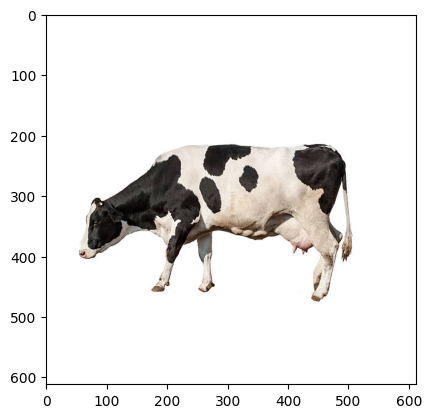

In [31]:
plt.imshow(cow_left_image[:, :, ::-1])

In [7]:
import torch
from PIL import Image
from torchvision.utils import make_grid
import numpy as np
from diffusion import add_texture_to_render
from dino import get_dino_features
from render import batch_render
from pytorch3d.ops import ball_query
from tqdm import tqdm
from time import time
import random


FEATURE_DIMS = 1280+768 # diffusion unet + dino

#TODO: changed for now
FEATURE_DIMS = 768 # diffusion unet + dino
VERTEX_GPU_LIMIT = 35000


def arange_pixels(
    resolution=(128, 128),
    batch_size=1,
    subsample_to=None,
    invert_y_axis=False,
    margin=0,
    corner_aligned=True,
    jitter=None,
):
    h, w = resolution
    n_points = resolution[0] * resolution[1]
    uh = 1 if corner_aligned else 1 - (1 / h)
    uw = 1 if corner_aligned else 1 - (1 / w)
    if margin > 0:
        uh = uh + (2 / h) * margin
        uw = uw + (2 / w) * margin
        w, h = w + margin * 2, h + margin * 2

    x, y = torch.linspace(-uw, uw, w), torch.linspace(-uh, uh, h)
    if jitter is not None:
        dx = (torch.ones_like(x).uniform_() - 0.5) * 2 / w * jitter
        dy = (torch.ones_like(y).uniform_() - 0.5) * 2 / h * jitter
        x, y = x + dx, y + dy
    x, y = torch.meshgrid(x, y)
    pixel_scaled = (
        torch.stack([x, y], -1)
        .permute(1, 0, 2)
        .reshape(1, -1, 2)
        .repeat(batch_size, 1, 1)
    )

    if subsample_to is not None and subsample_to > 0 and subsample_to < n_points:
        idx = np.random.choice(
            pixel_scaled.shape[1], size=(subsample_to,), replace=False
        )
        pixel_scaled = pixel_scaled[:, idx]

    if invert_y_axis:
        pixel_scaled[..., -1] *= -1.0

    return pixel_scaled


def get_features_per_vertex(
    device,
    pipe,
    dino_model,
    mesh,
    prompt,
    num_views=100,
    H=512,
    W=512,
    tolerance=0.01,
    use_latent=False,
    use_normal_map=True,
    num_images_per_prompt=1,
    mesh_vertices=None,
    return_image=True,
    bq=True,
    prompts_list=None,
    real_world_image=None
):
    t1 = time()
    if mesh_vertices is None:
        mesh_vertices = mesh.verts_list()[0]
    if len(mesh_vertices) > VERTEX_GPU_LIMIT:
        samples = random.sample(range(len(mesh_vertices)), 10000)
        maximal_distance = torch.cdist(mesh_vertices[samples], mesh_vertices[samples]).max()
    else:
        maximal_distance = torch.cdist(mesh_vertices, mesh_vertices).max()  # .cpu()
    ball_drop_radius = maximal_distance * tolerance
    batched_renderings, normal_batched_renderings, camera, depth = batch_render(
        device, mesh, mesh.verts_list()[0], num_views, H, W, use_normal_map
    )
    print("Rendering complete")
    if use_normal_map:
        normal_batched_renderings = normal_batched_renderings.cpu()
    batched_renderings = batched_renderings.cpu()
    pixel_coords = arange_pixels((H, W), invert_y_axis=True)[0]
    pixel_coords[:, 0] = torch.flip(pixel_coords[:, 0], dims=[0])
    grid = arange_pixels((H, W), invert_y_axis=False)[0].to(device).reshape(1, H, W, 2).half()
    camera = camera.cpu()
    normal_map_input = None
    depth = depth.cpu()
    torch.cuda.empty_cache()
    ft_per_vertex = torch.zeros((len(mesh_vertices), FEATURE_DIMS)).half()  # .to(device)
    ft_per_vertex_count = torch.zeros((len(mesh_vertices), 1)).half()  # .to(device)
    for idx in tqdm(range(len(batched_renderings))):
        dp = depth[idx].flatten().unsqueeze(1)
        xy_depth = torch.cat((pixel_coords, dp), dim=1)
        indices = xy_depth[:, 2] != -1
        xy_depth = xy_depth[indices]
        world_coords = (
            camera[idx].unproject_points(
                xy_depth, world_coordinates=True, from_ndc=True
            )  # .cpu()
        ).to(device)
        diffusion_input_img = (
            batched_renderings[idx, :, :, :3].cpu().numpy() * 255
        ).astype(np.uint8)
        if use_normal_map:
            normal_map_input = normal_batched_renderings[idx]
        depth_map = depth[idx, :, :, 0].unsqueeze(0).to(device)
        if prompts_list is not None:
            prompt = random.choice(prompts_list)
            
        # print("Depth map and normal map shapes: ", diffusion_input_img.shape, depth_map.shape, normal_map_input.shape if use_normal_map else "No normal map")
        diffusion_output = add_texture_to_render(
            pipe,
            diffusion_input_img,
            depth_map,
            prompt,
            normal_map_input=normal_map_input,
            use_latent=use_latent,
            num_images_per_prompt=num_images_per_prompt,
            return_image=return_image
        )
        # print("Diffusion output: ", diffusion_output[0].shape, diffusion_output[1][0].shape)
        aligned_dino_features = get_dino_features(device, dino_model, diffusion_output[1][0], grid)
        aligned_features = None
        with torch.no_grad():
            ft = torch.nn.Upsample(size=(H,W), mode="bilinear")(diffusion_output[0].unsqueeze(0)).to(device)
            # print("Feature map shape: ", ft.shape)
            ft_dim = ft.size(1)
            aligned_features = torch.nn.functional.grid_sample(
                ft, grid, align_corners=False
            )
            # print("Aligned features shape: ", aligned_features.shape)
            aligned_features = aligned_features.reshape(1, ft_dim, -1)
            aligned_features = torch.nn.functional.normalize(aligned_features, dim=1)
        # this is feature per pixel in the grid
        
        #TODO: changed for now
        # aligned_features = torch.hstack([aligned_features*0.5, aligned_dino_features*0.5])
        aligned_features = aligned_dino_features
        
        features_per_pixel = aligned_features[0, :, indices].cpu()
        
        # print("Features per pixel shape: ", aligned_features.shape)
        # TODO: take real world image pixel features
        # map pixel to vertex on mesh
        if bq:
            queried_indices = (
                ball_query(
                    world_coords.unsqueeze(0),
                    mesh_vertices.unsqueeze(0),
                    K=100,
                    radius=ball_drop_radius,
                    return_nn=False,
                )
                .idx[0]
                .cpu()
            )
            mask = queried_indices != -1
            repeat = mask.sum(dim=1)
            ft_per_vertex_count[queried_indices[mask]] += 1
            ft_per_vertex[queried_indices[mask]] += features_per_pixel.repeat_interleave(
                repeat, dim=1
            ).T
        else:
            distances = torch.cdist(
            world_coords, mesh_vertices, p=2
            )
            closest_vertex_indices = torch.argmin(distances, dim=1).cpu()
            ft_per_vertex[closest_vertex_indices] += features_per_pixel.T
            ft_per_vertex_count[closest_vertex_indices] += 1

    idxs = (ft_per_vertex_count != 0)[:, 0]
    ft_per_vertex[idxs, :] = ft_per_vertex[idxs, :] / ft_per_vertex_count[idxs, :]
    missing_features = len(ft_per_vertex_count[ft_per_vertex_count == 0])
    print("Number of missing features: ", missing_features)
    print("Copied features from nearest vertices")

    if missing_features > 0:
        filled_indices = ft_per_vertex_count[:, 0] != 0
        missing_indices = ft_per_vertex_count[:, 0] == 0
        distances = torch.cdist(
            mesh_vertices[missing_indices], mesh_vertices[filled_indices], p=2
        )
        closest_vertex_indices = torch.argmin(distances, dim=1).cpu()
        ft_per_vertex[missing_indices, :] = ft_per_vertex[filled_indices][
            closest_vertex_indices, :
        ]
    t2 = time() - t1
    t2 = t2 / 60
    print("Time taken in mins: ", t2)
    return ft_per_vertex


In [14]:
import torch
from PIL import Image
from torchvision.utils import make_grid
import numpy as np
from diffusion import add_texture_to_render
from dino_copy import get_dino_features
from render import batch_render
from pytorch3d.ops import ball_query
from tqdm import tqdm
from time import time
import random


FEATURE_DIMS = 1280+768 # diffusion unet + dino
VERTEX_GPU_LIMIT = 35000
W_feat = H_feat = 37  # Assuming a fixed feature map size for DINO features


def arange_pixels(
    resolution=(128, 128),
    batch_size=1,
    subsample_to=None,
    invert_y_axis=False,
    margin=0,
    corner_aligned=True,
    jitter=None,
):
    h, w = resolution
    n_points = resolution[0] * resolution[1]
    uh = 1 if corner_aligned else 1 - (1 / h)
    uw = 1 if corner_aligned else 1 - (1 / w)
    if margin > 0:
        uh = uh + (2 / h) * margin
        uw = uw + (2 / w) * margin
        w, h = w + margin * 2, h + margin * 2

    x, y = torch.linspace(-uw, uw, w), torch.linspace(-uh, uh, h)
    if jitter is not None:
        dx = (torch.ones_like(x).uniform_() - 0.5) * 2 / w * jitter
        dy = (torch.ones_like(y).uniform_() - 0.5) * 2 / h * jitter
        x, y = x + dx, y + dy
    x, y = torch.meshgrid(x, y)
    pixel_scaled = (
        torch.stack([x, y], -1)
        .permute(1, 0, 2)
        .reshape(1, -1, 2)
        .repeat(batch_size, 1, 1)
    )

    if subsample_to is not None and subsample_to > 0 and subsample_to < n_points:
        idx = np.random.choice(
            pixel_scaled.shape[1], size=(subsample_to,), replace=False
        )
        pixel_scaled = pixel_scaled[:, idx]

    if invert_y_axis:
        pixel_scaled[..., -1] *= -1.0

    return pixel_scaled


# --- 4. Visualization ---
def get_coords(patch_idx, H_orig, W_orig):
    """Converts a 1D patch index to 2D image coordinates."""
    h_feat = patch_idx // W_feat
    w_feat = patch_idx % W_feat
    
    # Scale to original image size
    x = (w_feat + 0.5) * (W_orig / W_feat)
    y = (h_feat + 0.5) * (H_orig / H_feat)
    return x, y

def plot_high_quality_correspondences(img1, img2, similarity_matrix, threshold=0.8, num_to_plot=30):
    """
    Finds and plots high-quality correspondences by applying MNN and thresholding filters.
    """
    if isinstance(img1, np.ndarray): img1 = Image.fromarray(img1)
    if isinstance(img2, np.ndarray): img2 = Image.fromarray(img2)

    scores, best_matches_1_to_2 = torch.max(similarity_matrix, dim=1)
    best_matches_2_to_1 = torch.max(similarity_matrix, dim=0)[1]

    # 2. MNN Filter
    p_indices = torch.arange(len(best_matches_1_to_2), device=similarity_matrix.device)
    mutual_mask = (best_matches_2_to_1[best_matches_1_to_2] == p_indices)

    # 3. Score Threshold Filter
    score_mask = scores > threshold

    # 4. Combine filters
    quality_mask = mutual_mask & score_mask

    # 5. Get the final, high-quality patch indices
    src_indices = p_indices[quality_mask]
    tgt_indices = best_matches_1_to_2[quality_mask]
    match_scores = scores[quality_mask]
    
    print(f"Total potential matches: {len(p_indices)}")
    print(f"Found {mutual_mask.sum()} mutual matches.")
    print(f"Found {score_mask.sum()} matches above threshold {threshold}.")
    print(f"Found {len(src_indices)} final high-quality matches.")
    
    if len(src_indices) == 0:
        print("No high-quality matches found. Try lowering the threshold.")
        return

    # --- Visualization ---
    # Sort by score to plot the best ones first
    sorted_indices = torch.argsort(match_scores, descending=True)
    src_indices = src_indices[sorted_indices]
    tgt_indices = tgt_indices[sorted_indices]

    # Limit the number of plotted matches for clarity
    if num_to_plot > len(src_indices):
        num_to_plot = len(src_indices)
    src_indices = src_indices[:num_to_plot]
    tgt_indices = tgt_indices[:num_to_plot]

    # The rest of the plotting logic is the same as before
    W1, H1 = img1.size
    W2, H2 = img2.size
    combined_img = Image.new('RGB', (W1 + W2, max(H1, H2)))
    combined_img.paste(img1, (0, 0, W1, H1))
    combined_img.paste(img2, (W1, 0, W1 + W2, H2))

    fig, ax = plt.subplots(figsize=(15, 8))
    ax.imshow(combined_img)
    ax.axis('off')

    for idx1, idx2 in zip(src_indices, tgt_indices):
        x1, y1 = get_coords(idx1.item(), H1, W1)
        x2, y2 = get_coords(idx2.item(), H2, W2)
        x2_adj = x2 + W1
        
        color = np.random.rand(3,)
        ax.plot([x1, x2_adj], [y1, y2], color=color, linewidth=1.5)
        ax.scatter([x1, x2_adj], [y1, y2], s=20, color=color, marker='o')

    plt.title(f'Top {num_to_plot} High-Quality DINOv2 Correspondences (MNN + Threshold)')
    plt.tight_layout()
    plt.show()
    
    
def plot_correspondences(img1, img2, matches, num_to_plot=20):
    W1, H1 = img1.size
    W2, H2 = img2.size

    # Create a combined image
    combined_width = W1 + W2
    combined_height = max(H1, H2)
    combined_img = Image.new('RGB', (combined_width, combined_height))

    # --- THIS IS THE FIX ---
    # Use a 4-item box (left, top, right, bottom) for pasting
    combined_img.paste(img1, (0, 0, W1, H1))
    combined_img.paste(img2, (W1, 0, W1 + W2, H2))
    # --- END OF FIX ---

    fig, ax = plt.subplots(figsize=(15, 8))
    ax.imshow(combined_img)
    ax.axis('off')

    # Select a random subset of matches to plot for clarity
    num_patches = len(matches)
    # Ensure num_to_plot is not greater than the number of available patches
    if num_to_plot > num_patches:
        num_to_plot = num_patches
        
    indices_to_plot = np.random.choice(num_patches, num_to_plot, replace=False)

    for idx1 in indices_to_plot:
        idx2 = matches[idx1].item()
        
        # Get coordinates for image 1
        # (Assuming W_feat and H_feat are defined globally or passed as arguments)
        x1, y1 = get_coords(idx1, H1, W1)
        
        # Get coordinates for image 2
        x2, y2 = get_coords(idx2, H2, W2)
        
        # Adjust x2 for the combined image
        x2_adj = x2 + W1
        
        # Plot the line
        color = np.random.rand(3,)
        ax.plot([x1, x2_adj], [y1, y2], color=color, linewidth=1.5, alpha=0.8)
        ax.scatter([x1, x2_adj], [y1, y2], s=25, color=color, marker='o')

    plt.title(f'DINOv2 Correspondences ({num_to_plot} random matches)')
    plt.tight_layout()
    plt.show()

# Plot the results
def get_features_per_vertex(
    device,
    pipe,
    dino_model,
    mesh,
    prompt,
    num_views=100,
    H=512,
    W=512,
    tolerance=0.01,
    use_latent=False,
    use_normal_map=True,
    num_images_per_prompt=1,
    mesh_vertices=None,
    return_image=True,
    bq=True,
    prompts_list=None,
    real_world_image=None,  # New argument for real-world image
):
    t1 = time()
    if mesh_vertices is None:
        mesh_vertices = mesh.verts_list()[0]
    if len(mesh_vertices) > VERTEX_GPU_LIMIT:
        samples = random.sample(range(len(mesh_vertices)), 10000)
        maximal_distance = torch.cdist(mesh_vertices[samples], mesh_vertices[samples]).max()
    else:
        maximal_distance = torch.cdist(mesh_vertices, mesh_vertices).max()
    ball_drop_radius = maximal_distance * tolerance
    batched_renderings, normal_batched_renderings, camera, depth = batch_render(
        device, mesh, mesh.verts_list()[0], num_views, H, W, use_normal_map
    )
    print("Rendering complete")
    if use_normal_map:
        normal_batched_renderings = normal_batched_renderings.cpu()
    batched_renderings = batched_renderings.cpu()
    pixel_coords = arange_pixels((H, W), invert_y_axis=True)[0]
    pixel_coords[:, 0] = torch.flip(pixel_coords[:, 0], dims=[0])
    grid = arange_pixels((H, W), invert_y_axis=False)[0].to(device).reshape(1, H, W, 2).half()
    camera = camera.cpu()
    normal_map_input = None
    depth = depth.cpu()
    torch.cuda.empty_cache()
    ft_per_vertex = torch.zeros((len(mesh_vertices), FEATURE_DIMS)).half()
    ft_per_vertex_count = torch.zeros((len(mesh_vertices), 1)).half()
    
    H, W = 37, 37
    N = H * W # 1024

    # Compute features for the real-world image
    if real_world_image is not None:
        real_world_image_numpy = real_world_image.copy()
        # real_world_image_tensor = torch.tensor(real_world_image_copy).permute(2, 0, 1).unsqueeze(0).to(device) / 255.0
        real_world_dino_features, _ = get_dino_features(device, dino_model, real_world_image_numpy, grid)
        # real_world_diffusion_features = add_texture_to_render(
        #     pipe,
        #     real_world_image,
        #     None,  # No depth map for real-world image
        #     prompt,
        #     normal_map_input=None,
        #     use_latent=use_latent,
        #     num_images_per_prompt=1,
        #     return_image=False
        # )[0].unsqueeze(0).to(device)
        # real_world_diffusion_features = torch.nn.functional.normalize(real_world_diffusion_features, dim=1)
        # real_world_dino_features = torch.nn.functional.normalize(real_world_dino_features, dim=1)
        print("Real-world DINO features shape:", real_world_dino_features.shape)
        real_world_dino_features = real_world_dino_features.reshape(1, -1, N).permute(0, 2, 1).squeeze(0)
        print("Real-world DINO features shape:", real_world_dino_features.shape)

    for idx in tqdm(range(len(batched_renderings))):
        dp = depth[idx].flatten().unsqueeze(1)
        xy_depth = torch.cat((pixel_coords, dp), dim=1)
        indices = xy_depth[:, 2] != -1
        xy_depth = xy_depth[indices]
        world_coords = (
            camera[idx].unproject_points(
                xy_depth, world_coordinates=True, from_ndc=True
            )
        ).to(device)
        diffusion_input_img = (
            batched_renderings[idx, :, :, :3].cpu().numpy() * 255
        ).astype(np.uint8)
        if use_normal_map:
            normal_map_input = normal_batched_renderings[idx]
        depth_map = depth[idx, :, :, 0].unsqueeze(0).to(device)
        if prompts_list is not None:
            prompt = random.choice(prompts_list)
        diffusion_output = add_texture_to_render(
            pipe,
            diffusion_input_img,
            depth_map,
            prompt,
            normal_map_input=normal_map_input,
            use_latent=use_latent,
            num_images_per_prompt=num_images_per_prompt,
            return_image=return_image
        )
        # print("Diffusion output shape:", np.array(diffusion_output[1][0]))
        aligned_dino_features, aligned_dino_features_orig_shape = get_dino_features(device, dino_model, diffusion_output[1][0], grid)
        print("Aligned DINO features shape:", aligned_dino_features.shape)
        print("Aligned DINO features original shape:", aligned_dino_features_orig_shape.shape)
        
        aligned_dino_features = aligned_dino_features.reshape(1, -1, N).permute(0, 2, 1).squeeze(0)
        print("Aligned DINO features shape:", aligned_dino_features.shape)
        # aligned_features = None
        # with torch.no_grad():
        #     ft = torch.nn.Upsample(size=(H, W), mode="bilinear")(diffusion_output[0].unsqueeze(0)).to(device)
        #     ft_dim = ft.size(1)
        #     aligned_features = torch.nn.functional.grid_sample(
        #         ft, grid, align_corners=False
        #     ).reshape(1, ft_dim, -1)
        #     aligned_features = torch.nn.functional.normalize(aligned_features, dim=1)
        # aligned_features = torch.hstack([aligned_features * 0.5, aligned_dino_features * 0.5])
        # print("Aligned features shape:", aligned_features.shape)
        # features_per_pixel = aligned_features[0, :, indices].cpu()
        # print("Features per pixel shape:", features_per_pixel.shape)
        # Compute cosine similarity with real-world image features
        if real_world_image is not None:
            # cosine_similarity_dino = torch.nn.functional.cosine_similarity(
            #     real_world_dino_features, aligned_dino_features, dim=1
            # )
            # cosine_similarity_diffusion = torch.nn.functional.cosine_similarity(
            #     real_world_diffusion_features, aligned_features[:, :FEATURE_DIMS], dim=1
            # )
            real_world_dino_features_norm = real_world_dino_features / torch.linalg.norm(real_world_dino_features, dim=1, keepdim=True)
            aligned_features_norm = aligned_dino_features / torch.linalg.norm(aligned_dino_features, dim=1, keepdim=True)

            similarity_matrix = torch.mm(real_world_dino_features_norm, aligned_features_norm.T)
            
            best_matches = torch.argmax(similarity_matrix, dim=1)
            
            real_world_image_pil = Image.fromarray(real_world_image_numpy)
            # plot_correspondences(real_world_image_pil, diffusion_output[1][0], best_matches, num_to_plot=30)
            plot_high_quality_correspondences(real_world_image_pil, diffusion_output[1][0], similarity_matrix, threshold=0.85, num_to_plot=50)
            # print("Cosine similarity (DINO):", cosine_similarity_dino.mean().item())
            # print("Cosine similarity (Diffusion):", cosine_similarity_diffusion.mean().item())

        # Map pixel to vertex on mesh
        # if bq:
        #     queried_indices = (
        #         ball_query(
        #             world_coords.unsqueeze(0),
        #             mesh_vertices.unsqueeze(0),
        #             K=100,
        #             radius=ball_drop_radius,
        #             return_nn=False,
        #         )
        #         .idx[0]
        #         .cpu()
        #     )
        #     mask = queried_indices != -1
        #     repeat = mask.sum(dim=1)
        #     ft_per_vertex_count[queried_indices[mask]] += 1
        #     ft_per_vertex[queried_indices[mask]] += features_per_pixel.repeat_interleave(
        #         repeat, dim=1
        #     ).T
        # else:
        #     distances = torch.cdist(
        #         world_coords, mesh_vertices, p=2
        #     )
        #     closest_vertex_indices = torch.argmin(distances, dim=1).cpu()
        #     ft_per_vertex[closest_vertex_indices] += features_per_pixel.T
        #     ft_per_vertex_count[closest_vertex_indices] += 1

    idxs = (ft_per_vertex_count != 0)[:, 0]
    ft_per_vertex[idxs, :] = ft_per_vertex[idxs, :] / ft_per_vertex_count[idxs, :]
    missing_features = len(ft_per_vertex_count[ft_per_vertex_count == 0])
    print("Number of missing features: ", missing_features)
    print("Copied features from nearest vertices")
    if missing_features > 0:
        filled_indices = ft_per_vertex_count[:, 0] != 0
        missing_indices = ft_per_vertex_count[:, 0] == 0
        distances = torch.cdist(
            mesh_vertices[missing_indices], mesh_vertices[filled_indices], p=2
        )
        closest_vertex_indices = torch.argmin(distances, dim=1).cpu()
        ft_per_vertex[missing_indices, :] = ft_per_vertex[filled_indices][
            closest_vertex_indices, :
        ]
    t2 = time() - t1
    t2 = t2 / 60
    print("Time taken in mins: ", t2)
    return ft_per_vertex

In [8]:

# Plot the results
def get_features_per_pixel(
    device,
    dino_model,
    prompt,
    H=512,
    W=512,
    real_world_image=None,  # New argument for real-world image
):
   
    grid = arange_pixels((H, W), invert_y_axis=False)[0].to(device).reshape(1, H, W, 2).half()
    torch.cuda.empty_cache()

    # Compute features for the real-world image
    real_world_image_numpy = real_world_image.copy()
    # real_world_image_pil = Image.fromarray(real_world_image_numpy)

    # real_world_image_tensor = torch.tensor(real_world_image_copy).permute(2, 0, 1).unsqueeze(0).to(device) / 255.0
    # _, real_world_dino_features = get_dino_features(device, dino_model, real_world_image_numpy, grid)
    # print("Real-world DINO features shape:", real_world_dino_features.shape)
    
    # real_world_depth_map = torch.randint(0, 255, (1, H, W))
    # real_world_normal_map = torch.randint(0, 255, (H, W, 1, 3))
    
    # print("real world image shape: ", real_world_image_numpy.shape)
    # # get diffusion features for real-world image
    # diffusion_output = add_texture_to_render(
    #     pipe,
    #     real_world_image_numpy,
    #     real_world_depth_map,  # No depth map for real-world image
    #     prompt,
    #     normal_map_input=real_world_normal_map,
    #     use_latent=False,
    #     num_images_per_prompt=1,
    #     return_image=True
    # )
    
    aligned_features = get_dino_features(device, dino_model, Image.fromarray(real_world_image_numpy), grid)
    # aligned_features = None
    # with torch.no_grad():
    #     ft = torch.nn.Upsample(size=(H,W), mode="bilinear")(diffusion_output[0].unsqueeze(0)).to(device)
    #     print("Feature map shape: ", ft.shape)
    #     ft_dim = ft.size(1)
    #     aligned_features = torch.nn.functional.grid_sample(
    #         ft, grid, align_corners=False
    #     )
    #     print("Aligned features shape: ", aligned_features.shape)
    #     aligned_features = aligned_features.reshape(1, ft_dim, -1)
    #     aligned_features = torch.nn.functional.normalize(aligned_features, dim=1)
    # # this is feature per pixel in the grid
    # aligned_features = torch.hstack([aligned_features*0.5, aligned_dino_features*0.5])

    return aligned_features.reshape(1, -1, H, W).permute(0, 2, 3, 1).squeeze(0)

In [9]:
real_image.shape

(600, 600, 3)

In [43]:
cow_features = get_features_per_pixel(device, dino_model, "cow", H=cow_image.shape[0], W=cow_image.shape[1], real_world_image=cow_image)
cow_left_features = get_features_per_pixel(device, dino_model, "cow", H=cow_left_image.shape[0], W=cow_left_image.shape[1], real_world_image=cow_left_image)
cow_front_features = get_features_per_pixel(device, dino_model, "cow", H=cow_front_image.shape[0], W=cow_front_image.shape[1], real_world_image=cow_front_image)
cow_back_features = get_features_per_pixel(device, dino_model, "cow", H=cow_back_image.shape[0], W=cow_back_image.shape[1], real_world_image=cow_back_image)

print()
print(cow_front_features.shape)


torch.Size([600, 600, 768])


In [15]:
# plt.imshow(real_image[:, :, ::-1])

In [11]:
f_source = compute_features(device, pipe, dino_model, source_mesh, "cow", real_world_image = None) # (N_vertices, 2048)

Rendering complete


100%|██████████| 100/100 [04:03<00:00,  2.43s/it]

Number of missing features:  8
Copied features from nearest vertices
Time taken in mins:  4.119507332642873


In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import meshplot as mp

def visualize_pixel_to_mesh_correspondence(target_mesh, image_features, mesh_features, query_row, query_col, device='cpu'):

    H, W, NDIM = image_features.shape
    if not (0 <= query_row < H and 0 <= query_col < W):
        raise ValueError("Query pixel indices out of bounds.")
    
    image_features = image_features.to(device)
    mesh_features = mesh_features.to(device)
    
    query_feature = image_features[query_row, query_col].float()  # Shape: (NDIM,)
    
    mesh_features = mesh_features.float()  # Shape: (V, NDIM)
    
    similarity = torch.matmul(mesh_features, query_feature)  # Shape: (V,)
    
    min_sim = similarity.min()
    max_sim = similarity.max()
    if max_sim > min_sim:  # Avoid division by zero
        normalized_sim = (similarity - min_sim) / (max_sim - min_sim)
    else:
        normalized_sim = torch.zeros_like(similarity)  # If all similarities are equal
    
    normalized_sim_np = normalized_sim.cpu().numpy()
    
    cmap = plt.get_cmap('coolwarm')
    cmap_mesh = cmap(normalized_sim_np)[:, :3]  # RGB colors for mesh vertices (V, 3)
    
    best_match_idx = similarity.argmax().item()
    best_match_vertex = target_mesh.vert[best_match_idx]  # 3D coordinates of the best vertex
    print(f"Best matching vertex in target mesh: index {best_match_idx} "
          f"(similarity: {similarity[best_match_idx]:.4f})")
    
    p = mp.plot(target_mesh.vert, target_mesh.face, c=cmap_mesh, return_plot=True)
    
    # Add a red marker at the best matching vertex
    p.add_points(
        np.array([best_match_vertex]),  # Single point as (1, 3) array
        c=np.array([[0, 1, 0]]),  # Green color
        shading={"point_size": 0.1}  # Adjust size as needed
    )
    
    return p  

In [34]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import meshplot as mp
from IPython.display import display, HTML

def visualize_pixel_to_mesh_correspondence(target_mesh, image, image_features, mesh_features, query_row, query_col, device='cuda:0'):

    H, W, NDIM = image_features.shape
    if not (0 <= query_row < H and 0 <= query_col < W):
        raise ValueError("Query pixel indices out of bounds.")
    
    # Ensure image is a numpy array and in [0, 1]
    image = np.asarray(image)
    if image.max() > 1:
        image = image / 255.0  # Normalize to [0, 1] if in [0, 255]
    
    # Move image_features and mesh_features to the specified device
    image_features = image_features.to(device)
    mesh_features = mesh_features.to(device)
    
    # Extract query pixel feature and move to device
    query_feature = image_features[query_row, query_col].float()  # Shape: (NDIM,)
    
    # Convert mesh features to float32 for better precision
    mesh_features = mesh_features.float()  # Shape: (V, NDIM)
    
    # Compute cosine similarity between the query pixel and all mesh vertices
    similarity = torch.matmul(mesh_features, query_feature)  # Shape: (V,)
    
    # Normalize similarity scores to [0, 1]
    min_sim = similarity.min()
    max_sim = similarity.max()
    if max_sim > min_sim:  # Avoid division by zero
        normalized_sim = (similarity - min_sim) / (max_sim - min_sim)
    else:
        normalized_sim = torch.zeros_like(similarity)  # If all similarities are equal
    
    # Convert to numpy for colormap
    normalized_sim_np = normalized_sim.cpu().numpy()
    
    # Map normalized similarities to a blue-to-red colormap
    cmap = plt.get_cmap('coolwarm')
    cmap_mesh = cmap(normalized_sim_np)[:, :3]  # RGB colors for mesh vertices (V, 3)
    
    # Find the best matching vertex
    best_match_idx = similarity.argmax().item()
    best_match_vertex = target_mesh.vert[best_match_idx]  # 3D coordinates of the best vertex
    print(f"Best matching vertex in target mesh: index {best_match_idx} "
          f"(similarity: {similarity[best_match_idx]:.4f})")
    
    # Create a figure for side-by-side visualization
    fig = plt.figure(figsize=(12, 5))
    
    # Plot the image with a red marker at the query pixel
    ax = fig.add_subplot(121)
    ax.imshow(image)
    ax.scatter(query_col, query_row, c='red', marker='o', s=100, label='Query Pixel')
    ax.set_title('Image with Query Pixel')
    ax.legend()
    ax.axis('on')
    
    # Plot the mesh with heatmap and marker
    mp_plot = mp.plot(
        target_mesh.vert,
        target_mesh.face,
        c=cmap_mesh,
        return_plot=True
    )
    mp_plot.add_points(
        np.array([best_match_vertex]),  # Single point as (1, 3) array
        c=np.array([[0, 1, 0]]),  # Red color
        shading={"point_size": 0.1}  # Adjust size as needed
    )
    
    display(plt.gcf())  # Display matplotlib figure
    plt.close(fig)  # Close to avoid duplicate display
    
    return mp_plot  

In [24]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import meshplot as mp
from IPython.display import display, HTML

def visualize_pixel_to_mesh_correspondence(target_mesh, image, image_features, mesh_features, query_row, query_col, device='cpu', flip_horizontal=False):
    """
    Visualize correspondence between a query pixel in the image (optionally flipped horizontally) and the target mesh vertices,
    displaying the image with a red marker at the query pixel and the mesh with a heatmap and a red marker at the best matching vertex, side by side.
    
    Args:
        target_mesh: Mesh object for the target mesh (with .vert attribute for vertices).
        image: Numpy array of shape (H, W, 3) representing the RGB image (values in [0, 1] or [0, 255]).
        image_features: Feature tensor for the image (H, W, NDIM).
        mesh_features: Feature tensor for target mesh vertices (V, NDIM).
        query_row: Row index of the query pixel in the original image (0 to H-1).
        query_col: Column index of the query pixel in the original image (0 to W-1).
        device: Device to perform computations on (default: 'cuda:0').
        flip_horizontal: If True, flip the image and features horizontally (default: False).
    """
    # Validate indices
    H, W, NDIM = image_features.shape
    if not (0 <= query_row < H and 0 <= query_col < W):
        raise ValueError("Query pixel indices out of bounds.")
    
    # Ensure image is a numpy array and in [0, 1]
    image = np.asarray(image)
    if image.max() > 1:
        image = image / 255.0  # Normalize to [0, 1] if in [0, 255]
    
    # Flip image and features horizontally if requested
    if flip_horizontal:
        image = np.fliplr(image)  # Flip image horizontally
        image_features = torch.flip(image_features, dims=[1])  # Flip features along width dimension
        # Adjust query_col for flipped image
        # query_col = W - 1 - query_col
    
    # Move image_features and mesh_features to the specified device
    image_features = image_features.to(device)
    mesh_features = mesh_features.to(device)
    
    # Extract query pixel feature and move to device
    query_feature = image_features[query_row, query_col].float()  # Shape: (NDIM,)
    
    # Convert mesh features to float32 for better precision
    mesh_features = mesh_features.float()  # Shape: (V, NDIM)
    
    # Compute cosine similarity between the query pixel and all mesh vertices
    similarity = torch.matmul(mesh_features, query_feature)  # Shape: (V,)
    
    # Normalize similarity scores to [0, 1]
    min_sim = similarity.min()
    max_sim = similarity.max()
    if max_sim > min_sim:  # Avoid division by zero
        normalized_sim = (similarity - min_sim) / (max_sim - min_sim)
    else:
        normalized_sim = torch.zeros_like(similarity)  # If all similarities are equal
    
    # Convert to numpy for colormap
    normalized_sim_np = normalized_sim.cpu().numpy()
    
    # Map normalized similarities to a blue-to-red colormap
    cmap = plt.get_cmap('coolwarm')
    cmap_mesh = cmap(normalized_sim_np)[:, :3]  # RGB colors for mesh vertices (V, 3)
    
    # Find the best matching vertex
    best_match_idx = similarity.argmax().item()
    best_match_vertex = target_mesh.vert[best_match_idx]  # 3D coordinates of the best vertex
    print(f"Best matching vertex in target mesh: index {best_match_idx} "
          f"(similarity: {similarity[best_match_idx]:.4f})")
    
    # Create a figure for side-by-side visualization
    fig = plt.figure(figsize=(12, 5))
    
    # Plot the image with a red marker at the query pixel
    ax = fig.add_subplot(121)
    ax.imshow(image)
    ax.scatter(query_col, query_row, c='red', marker='o', s=100, label='Query Pixel')
    ax.set_title(f"{'Flipped ' if flip_horizontal else ''}Image with Query Pixel")
    ax.legend()
    ax.axis('on')
    
    # Plot the mesh with heatmap and marker
    mp_plot = mp.plot(
        target_mesh.vert,
        target_mesh.face,
        c=cmap_mesh,
        return_plot=True
    )
    mp_plot.add_points(
        np.array([best_match_vertex]),  # Single point as (1, 3) array
        c=np.array([[0, 1, 0]]),  # Red color
        shading={"point_size": 0.1}  # Adjust size as needed
    )
    
    # Display both plots side by side in Jupyter
    display(plt.gcf())  # Display matplotlib figure
    plt.close(fig)  # Close to avoid duplicate display
    
    return mp_plot  # Return meshplot object for further customization

Best matching vertex in target mesh: index 1706 (similarity: 0.5687)


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

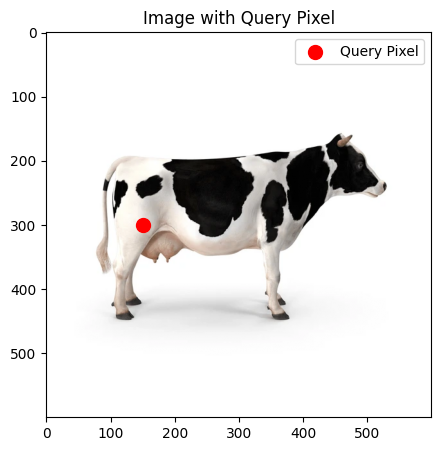

In [46]:
query_row, query_col = 300, 150 
visualize_pixel_to_mesh_correspondence(source_mesh, cow_image[:, :, ::-1], cow_features, f_source, query_row, query_col, device=device)

Best matching vertex in target mesh: index 291 (similarity: 0.5414)


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

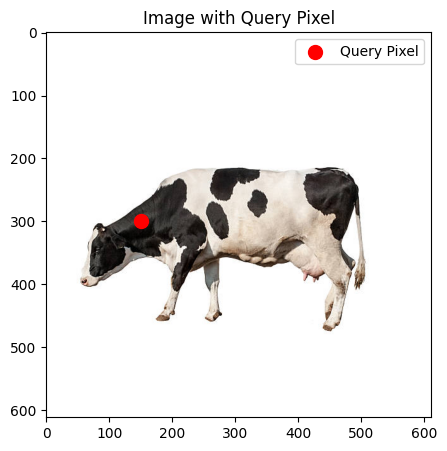

In [48]:
query_row, query_col = 300, 150 
visualize_pixel_to_mesh_correspondence(source_mesh, cow_left_image[:, :, ::-1], cow_left_features, f_source, query_row, query_col, device=device)

Best matching vertex in target mesh: index 365 (similarity: 0.5304)


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

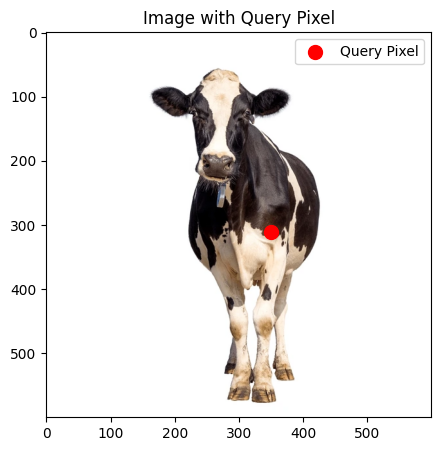

In [49]:
query_row, query_col = 310, 350 
visualize_pixel_to_mesh_correspondence(source_mesh, cow_front_image[:, :, ::-1], cow_front_features, f_source, query_row, query_col, device=device)

Best matching vertex in target mesh: index 2726 (similarity: 0.4892)


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

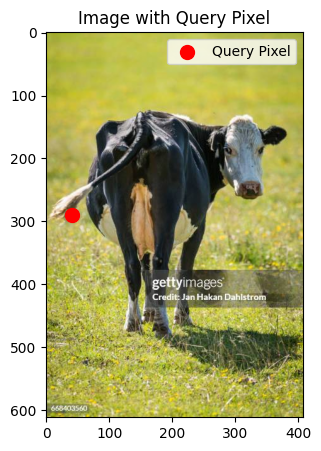

In [51]:
query_row, query_col = 290, 40 
visualize_pixel_to_mesh_correspondence(source_mesh, cow_back_image[:, :, ::-1], cow_back_features, f_source, query_row, query_col, device=device)

In [12]:
f_target = compute_features(device, pipe, dino_model, target_mesh, "camel")

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]], device='cuda:0')

In [7]:
f_target = compute_features(device, pipe, dino_model, target_mesh, "camel")

Rendering complete


100%|██████████| 100/100 [04:13<00:00,  2.54s/it]

Number of missing features:  2
Copied features from nearest vertices
Time taken in mins:  4.258294121424357


In [8]:
s = cosine_similarity(f_source.to(device),f_target.to(device))
s = torch.argmax(s, dim=0).cpu().numpy()
cmap_source = get_colors(source_mesh.vert); cmap_target = cmap_source[s]

In [9]:
double_plot(source_mesh,target_mesh,cmap_source,cmap_target)  

# Apply functional map on features

In [16]:
source_file_path = "meshes/cat.off"
target_file_path = "meshes/lion.off"
source_mesh = MeshContainer().load_from_file(source_file_path)
target_mesh = MeshContainer().load_from_file(target_file_path)
f_source = compute_features(device, pipe, dino_model, source_mesh, "cat")
f_target = compute_features(device, pipe, dino_model, target_mesh, "lion")

Rendering complete


100%|██████████| 100/100 [04:06<00:00,  2.47s/it]


Number of missing features:  140
Copied features from nearest vertices
Time taken in mins:  4.225214119752248
Rendering complete


100%|██████████| 100/100 [04:02<00:00,  2.43s/it]

Number of missing features:  17
Copied features from nearest vertices
Time taken in mins:  4.131702276070913


In [17]:
s = cosine_similarity(f_source.to(device),f_target.to(device))
s = torch.argmax(s, dim=0).cpu().numpy()
cmap_source = get_colors(source_mesh.vert); cmap_target = cmap_source[s]
double_plot(source_mesh,target_mesh,cmap_source,cmap_target)  

In [18]:
surface_map = compute_surface_map(source_file_path, target_file_path, f_source.numpy(), f_target.numpy())

mesh1 (7207, 3)
mesh2 (5000, 3)

Computing Laplacian spectrum
Computing 200 eigenvectors
	Done in 2.40 s
Computing 200 eigenvectors
	Done in 1.61 s

Computing descriptors
	Normalizing descriptors

	2048 out of 2048 possible descriptors kept
Computing commutativity operators
	Scaling LBO commutativity weight by 8.5e-10

Optimization :
	50 Ev on source - 50 Ev on Target
	Using 2048 Descriptors
	Hyperparameters :
		Descriptors preservation :1.0e+00
		Descriptors commutativity :1.0e-01
		Laplacian commutativity :1.0e-02
		Orientation preservation :0.0e+00

	Task : CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH, funcall : 16, nit : 13, warnflag : 0
	Done in 3.54 seconds


In [19]:
cmap_source = get_colors(source_mesh.vert); cmap_target = cmap_source[surface_map.cpu().numpy()]
double_plot(source_mesh,target_mesh,cmap_source,cmap_target)  

# Part segmentation

In [20]:
from sklearn.cluster import KMeans
import numpy as np

k = 6

kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto").fit(f_source)

segments1 = kmeans.predict(f_source)

# Apply centroids on another mesh to segment it in a corresponding manner
segments2 = kmeans.predict(f_target)

In [21]:
segment_colors = generate_colors(k)
cmap_source = np.array([segment_colors[j] for j in segments1])
cmap_target = np.array([segment_colors[j] for j in segments2])

In [25]:
double_plot(source_mesh,target_mesh,cmap_source,cmap_target)  

In [22]:
source_file_path = "meshes/posed_human.off"
target_file_path = "meshes/cat.off"
source_mesh = MeshContainer().load_from_file(source_file_path)
target_mesh = MeshContainer().load_from_file(target_file_path)
f_source = compute_features(device, pipe, dino_model, source_mesh, "naked human")
f_target = compute_features(device, pipe, dino_model, target_mesh, "cat")

Rendering complete


100%|██████████| 100/100 [04:00<00:00,  2.41s/it]


Number of missing features:  3
Copied features from nearest vertices
Time taken in mins:  4.100426765282949
Rendering complete


100%|██████████| 100/100 [04:07<00:00,  2.48s/it]

Number of missing features:  140
Copied features from nearest vertices
Time taken in mins:  4.232180142402649


In [23]:
k = 6

kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto").fit(f_source)

segments1 = kmeans.predict(f_source)

# Apply centroids on another mesh to segment it in a corresponding manner

segments2 = kmeans.predict(f_target)
segment_colors = generate_colors(k)
cmap_source = np.array([segment_colors[j] for j in segments1])
cmap_target = np.array([segment_colors[j] for j in segments2])

In [24]:
double_plot(source_mesh,target_mesh,cmap_source,cmap_target)  